In [1]:
import torch
import torch.nn.functional as F
with open('../names.txt') as f:
    words = f.read().splitlines()

In [2]:
# Create index representation of word/char
chars = sorted(list(set(''.join(words)+'.')))
idx2char = {idx:c for idx,c in enumerate(chars)}
char2idx = {c:idx for idx,c in enumerate(chars)}

In [3]:
# Build training dataset
block = 3
X, Y = [], []
for i in words:
    # print(i)
    context = [0] * block
    for j in (i+'.'):
        # x_word = ''.join([idx2char[k] for k in context])
        # print(f'{x_word} ------> {j}')
        X.append(context)
        Y.append(char2idx[j])
        context = context[1:] + [char2idx[j]]
X = torch.tensor(X)
Y = torch.tensor(Y)

In [4]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [5]:
# manually make a forward pass to get loss
emb_hidden = 2
C = torch.randn((len(char2idx), emb_hidden),requires_grad=True)
# emb can use onehot + @ or can use index C[X]
emb = F.one_hot(X,len(char2idx)).float() @ C
emb.shape

W1 = torch.randn((emb_hidden*block, 100),requires_grad=True)
b1 = torch.randn(100,requires_grad=True)
Z1 = emb.view(-1, emb_hidden*block) @ W1 + b1
A1 = Z1.tanh()

W2 = torch.randn((100, len(char2idx)),requires_grad=True)
b2 = torch.randn(len(char2idx),requires_grad=True)
A2 = A1 @ W2 + b2

prob = A2.exp() / A2.exp().sum(dim=1,keepdim=True)
loss = -prob[torch.arange(len(X)),Y].log().mean()
print(f'{loss=:.4f}')

loss=16.5258


In [6]:
# Again, group all parameters here and count total number of parameters
g = torch.Generator().manual_seed(1234)
emb_hidden = 2
hiddensize = 100

C = torch.randn((len(char2idx), emb_hidden),generator=g)
W1 = torch.randn((emb_hidden*block, hiddensize),generator=g)
b1 = torch.randn(hiddensize,generator=g)
W2 = torch.randn((hiddensize, len(char2idx)),generator=g)
b2 = torch.randn(len(char2idx),generator=g)
parameters = [C, W1, b1, W2, b2]
print('total num_of_parameters: ',sum([parameter.nelement() for parameter in parameters]))

total num_of_parameters:  3481


In [7]:
# set require grad to all params
for i in parameters:
    i.requires_grad = True

In [8]:
# train model, plot train loss
loss_hist = []
n_iter = 1000
for epoch in range(n_iter):
    minibatch = torch.randint(0,len(X), (10000,))
    emb = C[X[minibatch,:]]
    Z1 = emb.view(-1, block*emb_hidden) @ W1 + b1
    A1 = Z1.tanh()
    logits = A1 @ W2 + b2
    loss = F.cross_entropy(logits, Y[minibatch])
    for i in parameters:
        i.grad = None
    # if epoch%10 == 0:
    #     print(f"{epoch=}: {loss=:.4f}") 
    loss_hist.append(loss.item())
    loss.backward()
    for i in parameters:
        i.data -= 0.1 * i.grad


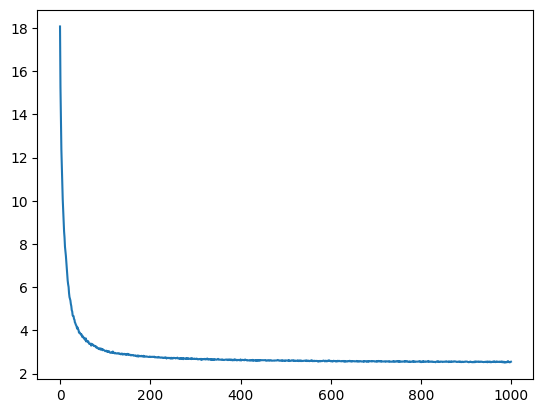

In [9]:
import matplotlib.pyplot as plt
plt.plot(list(range(n_iter)), loss_hist)

In [10]:
minibatch = torch.randint(0,len(X), (1000,))
emb = C[X]
Z1 = emb.view(-1, block*emb_hidden) @ W1 + b1
A1 = Z1.tanh()
logits = A1 @ W2 + b2
loss = F.cross_entropy(logits, Y)
print(loss.item())

2.535470962524414


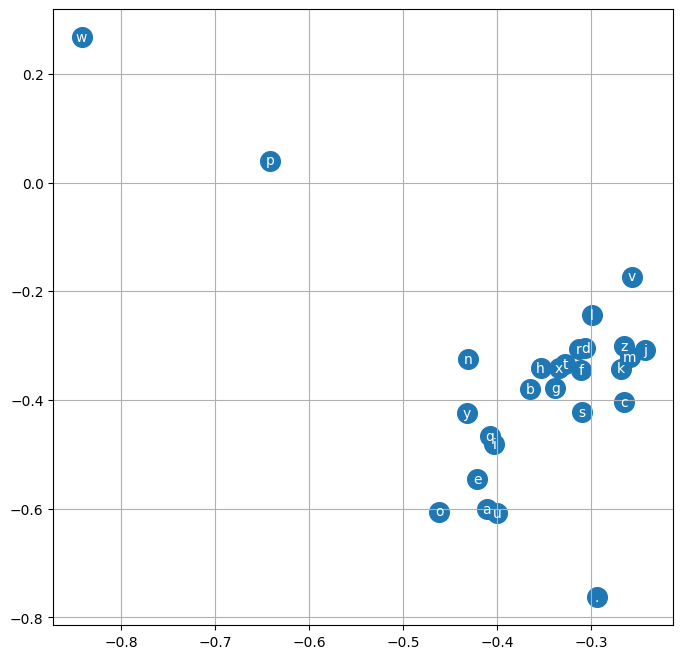

In [11]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), idx2char[i], ha="center", va="center", color='white')
plt.grid('minor')